# PyTorch vs TensorFlow → ONNX Comparison

Chuyển đổi models từ **PyTorch** và **TensorFlow** sang ONNX,
sau đó so sánh performance trên CPU và GPU.

## Models
1. **PyTorch**: ResNet18, MobileNetV2
2. **TensorFlow**: ResNet50V2, EfficientNetB0

## Comparison Metrics
- Inference time (ms)
- Throughput (FPS)
- Model size (MB)
- GPU/CPU speedup

## 1. Setup Environment

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
!pip install -q onnx onnxruntime-gpu onnxsim>=0.1.71 onnxscript
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q tensorflow tf2onnx
!pip install -q matplotlib seaborn pandas numpy

## 2. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as torch_models
import tensorflow as tf
from tensorflow import keras
import onnx
import onnxruntime as ort
import tf2onnx
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Print versions
print(f'PyTorch version: {torch.__version__}')
print(f'TensorFlow version: {tf.__version__}')
print(f'ONNX version: {onnx.__version__}')
print(f'ONNX Runtime version: {ort.__version__}')
print(f'CUDA available (PyTorch): {torch.cuda.is_available()}')
print(f'GPU available (TF): {len(tf.config.list_physical_devices("GPU")) > 0}')
if torch.cuda.is_available():
    print(f'GPU device: {torch.cuda.get_device_name(0)}')
print(f'ONNX Runtime providers: {ort.get_available_providers()}')

PyTorch version: 2.9.0+cu126
TensorFlow version: 2.19.0
ONNX version: 1.17.0
ONNX Runtime version: 1.23.2
CUDA available (PyTorch): True
GPU available (TF): True
GPU device: Tesla T4
ONNX Runtime providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


## 3. Create Directories

In [ ]:
os.makedirs('models/pytorch', exist_ok=True)
os.makedirs('models/tensorflow', exist_ok=True)
os.makedirs('results', exist_ok=True)
print('Directories created')

✅ Directories created


## 4. ONNX Inference Class

In [ ]:
class ONNXInference:
    def __init__(self, onnx_path: str, use_gpu: bool = True):
        if use_gpu and 'CUDAExecutionProvider' in ort.get_available_providers():
            providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
            self.device = 'GPU'
        else:
            providers = ['CPUExecutionProvider']
            self.device = 'CPU'

        sess_options = ort.SessionOptions()
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

        self.session = ort.InferenceSession(onnx_path, providers=providers, sess_options=sess_options)
        self.input_name = self.session.get_inputs()[0].name
        self.input_shape = self.session.get_inputs()[0].shape

        print(f'Model: {os.path.basename(onnx_path)}')
        print(f'Device: {self.device}')
        print(f'Input: {self.input_name} {self.input_shape}')

    def inference(self, input_data: np.ndarray):
        if input_data.dtype != np.float32:
            input_data = input_data.astype(np.float32)
        return self.session.run(None, {self.input_name: input_data})[0]

    def benchmark(self, input_data: np.ndarray, num_runs: int = 100, warmup: int = 10):
        for _ in range(warmup):
            self.inference(input_data)

        times = []
        for _ in range(num_runs):
            start = time.time()
            self.inference(input_data)
            times.append(time.time() - start)

        return {
            'mean': np.mean(times) * 1000,
            'std': np.std(times) * 1000,
            'fps': 1000.0 / (np.mean(times) * 1000),
            'device': self.device
        }

print('ONNXInference class defined')

✅ ONNXInference class defined


## 5. PyTorch Models

### 5.1 Convert PyTorch ResNet18 to ONNX

In [ ]:
print('='*60)
print('PyTorch ResNet18 → ONNX')
print('='*60)

pytorch_resnet18 = torch_models.resnet18(pretrained=True)
pytorch_resnet18.eval()

dummy_input = torch.randn(1, 3, 224, 224)

pytorch_resnet18_path = 'models/pytorch/resnet18.onnx'
torch.onnx.export(
    pytorch_resnet18,
    dummy_input,
    pytorch_resnet18_path,
    input_names=['input'],
    output_names=['output'],
    opset_version=18,
    do_constant_folding=True
)

onnx_model = onnx.load(pytorch_resnet18_path)
onnx.checker.check_model(onnx_model)
size_mb = os.path.getsize(pytorch_resnet18_path) / (1024 * 1024)
print(f'Exported: {pytorch_resnet18_path} ({size_mb:.2f} MB)')

PyTorch ResNet18 → ONNX
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
✅ Exported: models/pytorch/resnet18.onnx (0.08 MB)


### 5.2 Convert PyTorch MobileNetV2 to ONNX

In [ ]:
print('='*60)
print('PyTorch MobileNetV2 → ONNX')
print('='*60)

pytorch_mobilenet = torch_models.mobilenet_v2(pretrained=True)
pytorch_mobilenet.eval()

pytorch_mobilenet_path = 'models/pytorch/mobilenetv2.onnx'
torch.onnx.export(
    pytorch_mobilenet,
    dummy_input,
    pytorch_mobilenet_path,
    input_names=['input'],
    output_names=['output'],
    opset_version=18
)

onnx_model = onnx.load(pytorch_mobilenet_path)
onnx.checker.check_model(onnx_model)
size_mb = os.path.getsize(pytorch_mobilenet_path) / (1024 * 1024)
print(f'Exported: {pytorch_mobilenet_path} ({size_mb:.2f} MB)')

PyTorch MobileNetV2 → ONNX
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 104 of general pattern rewrite rules.
✅ Exported: models/pytorch/mobilenetv2.onnx (0.24 MB)


## 6. TensorFlow Models

### 6.1 Convert TensorFlow ResNet50V2 to ONNX

In [ ]:
print('='*60)
print('TensorFlow ResNet50V2 → ONNX')
print('='*60)

tf_resnet50 = keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=True,
    input_shape=(224, 224, 3)
)

tf_resnet50_path = 'models/tensorflow/resnet50v2.onnx'
spec = (tf.TensorSpec((1, 224, 224, 3), tf.float32, name='input'),)
model_proto, _ = tf2onnx.convert.from_keras(
    tf_resnet50,
    input_signature=spec,
    opset=18,
    output_path=tf_resnet50_path
)

size_mb = os.path.getsize(tf_resnet50_path) / (1024 * 1024)
print(f'Exported: {tf_resnet50_path} ({size_mb:.2f} MB)')

TensorFlow ResNet50V2 → ONNX


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7933c6597ce0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Exported: models/tensorflow/resnet50v2.onnx (97.55 MB)


### 6.2 Convert TensorFlow EfficientNetB0 to ONNX

In [ ]:
print('='*60)
print('TensorFlow EfficientNetB0 → ONNX')
print('='*60)

tf_efficientnet = keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=True,
    input_shape=(224, 224, 3)
)

tf_efficientnet_path = 'models/tensorflow/efficientnetb0.onnx'
model_proto, _ = tf2onnx.convert.from_keras(
    tf_efficientnet,
    input_signature=spec,
    opset=14,
    output_path=tf_efficientnet_path
)

size_mb = os.path.getsize(tf_efficientnet_path) / (1024 * 1024)
print(f'Exported: {tf_efficientnet_path} ({size_mb:.2f} MB)')

TensorFlow EfficientNetB0 → ONNX


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7933c6597ce0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Exported: models/tensorflow/efficientnetb0.onnx (20.21 MB)


## 7. Benchmark All Models

### 7.1 PyTorch Models

In [ ]:
dummy_np = np.random.randn(1, 3, 224, 224).astype(np.float32)
results = {}
has_cuda = torch.cuda.is_available()

# PyTorch ResNet18
print('\n' + '='*60)
print('Benchmarking PyTorch ResNet18')
print('='*60)

if has_cuda:
    print('GPU Benchmark...')
    resnet18_gpu = ONNXInference(pytorch_resnet18_path, use_gpu=True)
    res_gpu = resnet18_gpu.benchmark(dummy_np)
    print(f'GPU: {res_gpu["mean"]:.2f}ms, {res_gpu["fps"]:.2f} FPS\n')
else:
    res_gpu = None

print('CPU Benchmark...')
resnet18_cpu = ONNXInference(pytorch_resnet18_path, use_gpu=False)
res_cpu = resnet18_cpu.benchmark(dummy_np)
print(f'CPU: {res_cpu["mean"]:.2f}ms, {res_cpu["fps"]:.2f} FPS')

results['PyTorch ResNet18'] = {'gpu': res_gpu, 'cpu': res_cpu}

# PyTorch MobileNetV2
print('\n' + '='*60)
print('Benchmarking PyTorch MobileNetV2')
print('='*60)

if has_cuda:
    print('GPU Benchmark...')
    mobilenet_gpu = ONNXInference(pytorch_mobilenet_path, use_gpu=True)
    mob_gpu = mobilenet_gpu.benchmark(dummy_np)
    print(f'GPU: {mob_gpu["mean"]:.2f}ms, {mob_gpu["fps"]:.2f} FPS\n')
else:
    mob_gpu = None

print('CPU Benchmark...')
mobilenet_cpu = ONNXInference(pytorch_mobilenet_path, use_gpu=False)
mob_cpu = mobilenet_cpu.benchmark(dummy_np)
print(f'CPU: {mob_cpu["mean"]:.2f}ms, {mob_cpu["fps"]:.2f} FPS')

results['PyTorch MobileNetV2'] = {'gpu': mob_gpu, 'cpu': mob_cpu}


Benchmarking PyTorch ResNet18
GPU Benchmark...
Model: resnet18.onnx
Device: GPU
Input: input [1, 3, 224, 224]
GPU: 3.16ms, 316.61 FPS

CPU Benchmark...
Model: resnet18.onnx
Device: CPU
Input: input [1, 3, 224, 224]
CPU: 31.02ms, 32.24 FPS

Benchmarking PyTorch MobileNetV2
GPU Benchmark...
Model: mobilenetv2.onnx
Device: GPU
Input: input [1, 3, 224, 224]
GPU: 2.17ms, 461.27 FPS

CPU Benchmark...
Model: mobilenetv2.onnx
Device: CPU
Input: input [1, 3, 224, 224]
CPU: 7.90ms, 126.63 FPS


### 7.2 TensorFlow Models

In [ ]:
dummy_tf = np.random.randn(1, 224, 224, 3).astype(np.float32)

# TensorFlow ResNet50V2
print('\n' + '='*60)
print('Benchmarking TensorFlow ResNet50V2')
print('='*60)

if has_cuda:
    print('GPU Benchmark...')
    tf_resnet_gpu = ONNXInference(tf_resnet50_path, use_gpu=True)
    tf_res_gpu = tf_resnet_gpu.benchmark(dummy_tf)
    print(f'GPU: {tf_res_gpu["mean"]:.2f}ms, {tf_res_gpu["fps"]:.2f} FPS\n')
else:
    tf_res_gpu = None

print('CPU Benchmark...')
tf_resnet_cpu = ONNXInference(tf_resnet50_path, use_gpu=False)
tf_res_cpu = tf_resnet_cpu.benchmark(dummy_tf)
print(f'CPU: {tf_res_cpu["mean"]:.2f}ms, {tf_res_cpu["fps"]:.2f} FPS')

results['TF ResNet50V2'] = {'gpu': tf_res_gpu, 'cpu': tf_res_cpu}

# TensorFlow EfficientNetB0
print('\n' + '='*60)
print('Benchmarking TensorFlow EfficientNetB0')
print('='*60)

if has_cuda:
    print('GPU Benchmark...')
    tf_eff_gpu = ONNXInference(tf_efficientnet_path, use_gpu=True)
    tf_e_gpu = tf_eff_gpu.benchmark(dummy_tf)
    print(f'GPU: {tf_e_gpu["mean"]:.2f}ms, {tf_e_gpu["fps"]:.2f} FPS\n')
else:
    tf_e_gpu = None

print('CPU Benchmark...')
tf_eff_cpu = ONNXInference(tf_efficientnet_path, use_gpu=False)
tf_e_cpu = tf_eff_cpu.benchmark(dummy_tf)
print(f'CPU: {tf_e_cpu["mean"]:.2f}ms, {tf_e_cpu["fps"]:.2f} FPS')

results['TF EfficientNetB0'] = {'gpu': tf_e_gpu, 'cpu': tf_e_cpu}


Benchmarking TensorFlow ResNet50V2
GPU Benchmark...
Model: resnet50v2.onnx
Device: GPU
Input: input [1, 224, 224, 3]
GPU: 4.97ms, 201.16 FPS

CPU Benchmark...
Model: resnet50v2.onnx
Device: CPU
Input: input [1, 224, 224, 3]
CPU: 78.47ms, 12.74 FPS

Benchmarking TensorFlow EfficientNetB0
GPU Benchmark...
Model: efficientnetb0.onnx
Device: GPU
Input: input [1, 224, 224, 3]
GPU: 2.85ms, 350.52 FPS

CPU Benchmark...
Model: efficientnetb0.onnx
Device: CPU
Input: input [1, 224, 224, 3]
CPU: 26.16ms, 38.23 FPS


## 8. Summary Table

In [ ]:
print('\n' + '='*100)
print('BENCHMARK SUMMARY: PyTorch vs TensorFlow → ONNX Runtime')
print('='*100)

if has_cuda:
    print(f'{"Model":<30} {"GPU (ms)":<12} {"CPU (ms)":<12} {"GPU FPS":<12} {"CPU FPS":<12} {"Speedup":<10}')
    print('-'*100)

    for model_name, res in results.items():
        gpu_time = res['gpu']['mean'] if res['gpu'] else 0
        cpu_time = res['cpu']['mean']
        gpu_fps = res['gpu']['fps'] if res['gpu'] else 0
        cpu_fps = res['cpu']['fps']
        speedup = cpu_time / gpu_time if gpu_time > 0 else 0

        print(f'{model_name:<30} {gpu_time:<12.2f} {cpu_time:<12.2f} {gpu_fps:<12.2f} {cpu_fps:<12.2f} {speedup:<10.2f}x')
else:
    print(f'{"Model":<30} {"CPU (ms)":<15} {"CPU FPS":<12}')
    print('-'*60)

    for model_name, res in results.items():
        cpu_time = res['cpu']['mean']
        cpu_fps = res['cpu']['fps']
        print(f'{model_name:<30} {cpu_time:<15.2f} {cpu_fps:<12.2f}')

print('='*100)


BENCHMARK SUMMARY: PyTorch vs TensorFlow → ONNX Runtime
Model                          GPU (ms)     CPU (ms)     GPU FPS      CPU FPS      Speedup   
----------------------------------------------------------------------------------------------------
PyTorch ResNet18               3.16         31.02        316.61       32.24        9.82      x
PyTorch MobileNetV2            2.17         7.90         461.27       126.63       3.64      x
TF ResNet50V2                  4.97         78.47        201.16       12.74        15.78     x
TF EfficientNetB0              2.85         26.16        350.52       38.23        9.17      x


## 9. Visualization

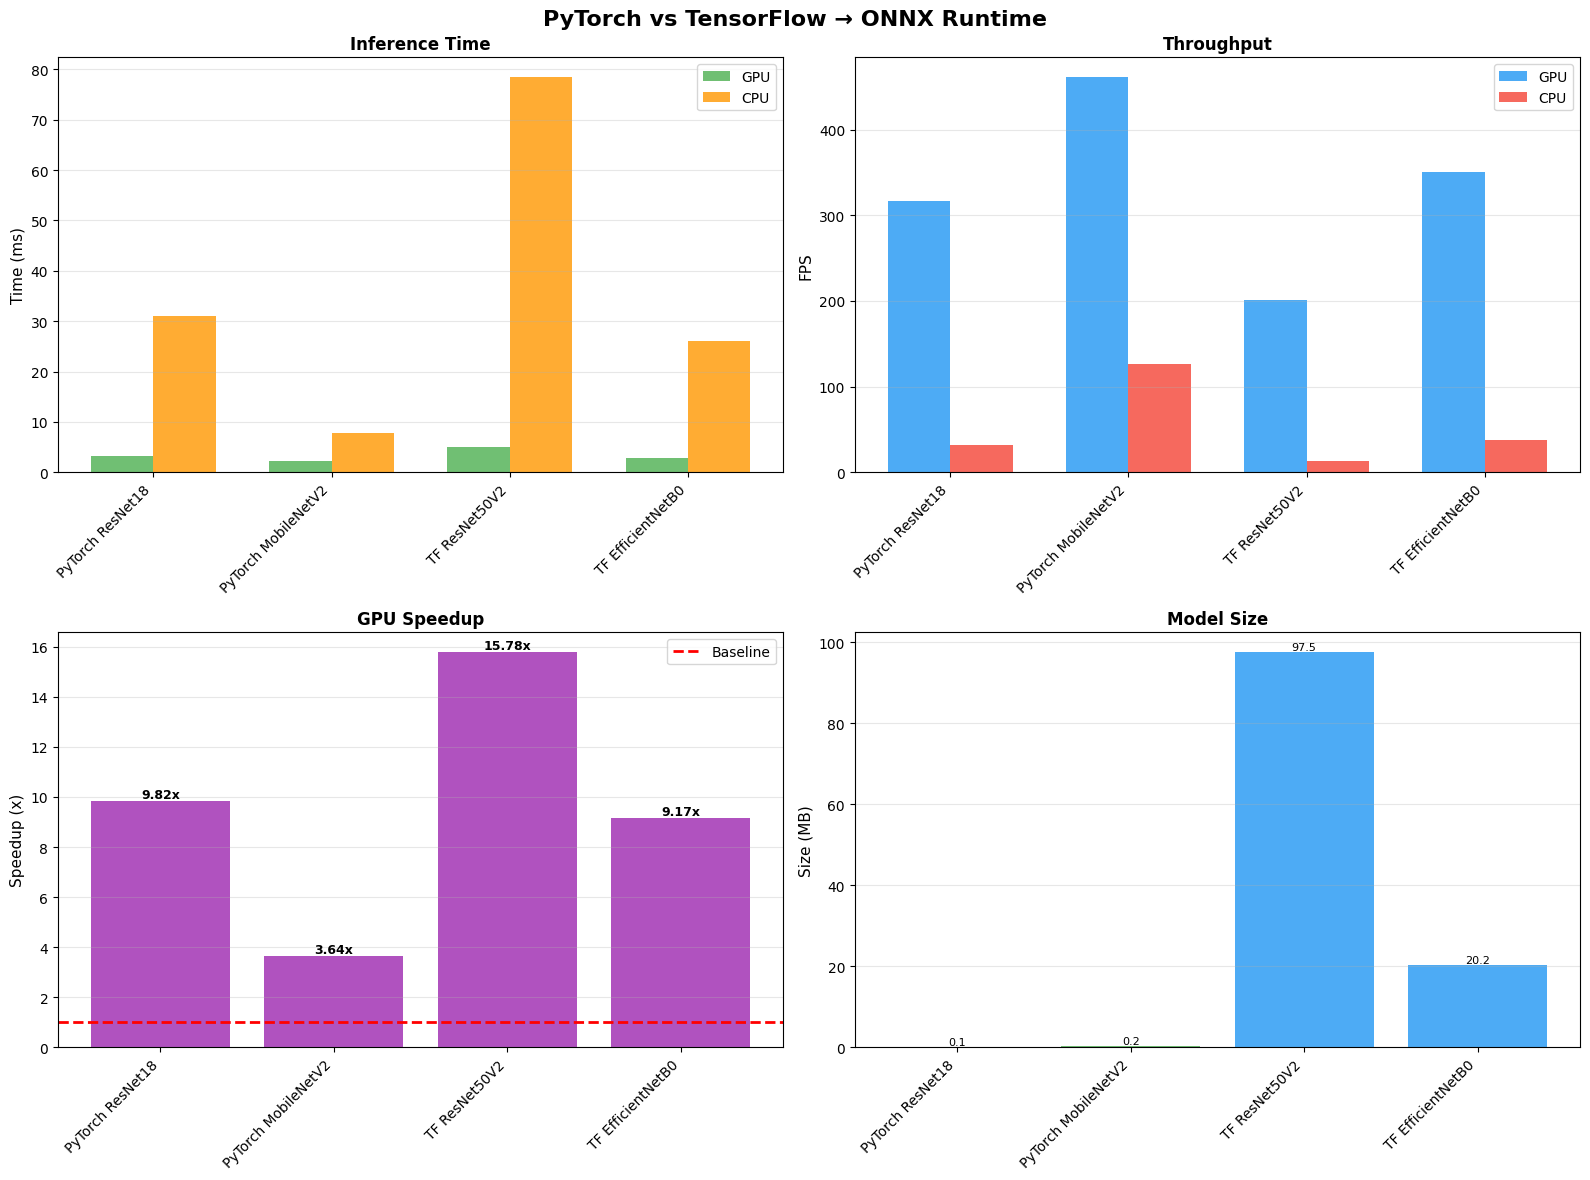


✅ Saved: results/comparison.png


In [ ]:
models_list = list(results.keys())
model_sizes = []

for model_name in models_list:
    if 'PyTorch ResNet18' in model_name:
        path = pytorch_resnet18_path
    elif 'PyTorch MobileNetV2' in model_name:
        path = pytorch_mobilenet_path
    elif 'TF ResNet50V2' in model_name:
        path = tf_resnet50_path
    elif 'TF EfficientNetB0' in model_name:
        path = tf_efficientnet_path

    size_mb = os.path.getsize(path) / (1024 * 1024)
    model_sizes.append(size_mb)

if has_cuda:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('PyTorch vs TensorFlow → ONNX Runtime', fontsize=16, fontweight='bold')

    gpu_times = [results[m]['gpu']['mean'] if results[m]['gpu'] else 0 for m in models_list]
    cpu_times = [results[m]['cpu']['mean'] for m in models_list]
    gpu_fps = [results[m]['gpu']['fps'] if results[m]['gpu'] else 0 for m in models_list]
    cpu_fps = [results[m]['cpu']['fps'] for m in models_list]

    x = np.arange(len(models_list))
    width = 0.35

    # Inference Time
    axes[0, 0].bar(x - width/2, gpu_times, width, label='GPU', color='#4CAF50', alpha=0.8)
    axes[0, 0].bar(x + width/2, cpu_times, width, label='CPU', color='#FF9800', alpha=0.8)
    axes[0, 0].set_ylabel('Time (ms)', fontsize=11)
    axes[0, 0].set_title('Inference Time', fontsize=12, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(models_list, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Throughput
    axes[0, 1].bar(x - width/2, gpu_fps, width, label='GPU', color='#2196F3', alpha=0.8)
    axes[0, 1].bar(x + width/2, cpu_fps, width, label='CPU', color='#F44336', alpha=0.8)
    axes[0, 1].set_ylabel('FPS', fontsize=11)
    axes[0, 1].set_title('Throughput', fontsize=12, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(models_list, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Speedup
    speedups = [cpu_times[i] / gpu_times[i] if gpu_times[i] > 0 else 0 for i in range(len(models_list))]
    bars = axes[1, 0].bar(models_list, speedups, color='#9C27B0', alpha=0.8)
    axes[1, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline')
    axes[1, 0].set_ylabel('Speedup (x)', fontsize=11)
    axes[1, 0].set_title('GPU Speedup', fontsize=12, fontweight='bold')
    axes[1, 0].set_xticklabels(models_list, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

    for bar, speedup in zip(bars, speedups):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{speedup:.2f}x', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Model Size
    colors = ['#4CAF50', '#4CAF50', '#2196F3', '#2196F3']
    bars = axes[1, 1].bar(models_list, model_sizes, color=colors, alpha=0.8)
    axes[1, 1].set_ylabel('Size (MB)', fontsize=11)
    axes[1, 1].set_title('Model Size', fontsize=12, fontweight='bold')
    axes[1, 1].set_xticklabels(models_list, rotation=45, ha='right')
    axes[1, 1].grid(axis='y', alpha=0.3)

    for bar, size in zip(bars, model_sizes):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{size:.1f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('results/comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\n✅ Saved: results/comparison.png')
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('PyTorch vs TensorFlow → ONNX (CPU)', fontsize=16, fontweight='bold')

    cpu_times = [results[m]['cpu']['mean'] for m in models_list]
    cpu_fps = [results[m]['cpu']['fps'] for m in models_list]

    axes[0].bar(models_list, cpu_times, color='#FF9800', alpha=0.8)
    axes[0].set_ylabel('Time (ms)', fontsize=11)
    axes[0].set_title('CPU Inference Time', fontsize=12, fontweight='bold')
    axes[0].set_xticklabels(models_list, rotation=45, ha='right')
    axes[0].grid(axis='y', alpha=0.3)

    axes[1].bar(models_list, cpu_fps, color='#F44336', alpha=0.8)
    axes[1].set_ylabel('FPS', fontsize=11)
    axes[1].set_title('CPU Throughput', fontsize=12, fontweight='bold')
    axes[1].set_xticklabels(models_list, rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/comparison_cpu.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\n✅ Saved: results/comparison_cpu.png')

## Conclusion
